In [64]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Iterable, Hashable
from collections import Counter, defaultdict

In [65]:
Feature = Hashable
Label = Hashable

Input = Iterable[Feature]

class NBClassifier:
    """
    A simple implementation of the Multinomial Naive Bayes Classifier
    (MultinomialNB) using Laplace smoothing and log-space computation for
    numeric stability.
    """

    def fit(self, X: Iterable[Input], y: Iterable[Label]):
        """
        Train the classifier by counting feature and class frequencies.
        """

        self.X = list(X)
        self.y = list(y)

        self.feature_counts = defaultdict(lambda: defaultdict(Counter))

        self.class_counts = Counter(self.y)
        self.class_labels = sorted(self.class_counts.keys())

        self.n_samples = len(self.y)

        n_features = len(self.X[0])

        for row, label in zip(self.X, self.y):
            for feature_index, feature_value in enumerate(row):
                if feature_value is None:
                    continue

                self.feature_counts[feature_index][label][feature_value] += 1

        self.feature_domains = {
            feature_index: set(row[feature_index] for row in self.X)
            for feature_index in range(n_features)
        }

    def prior(self, target_class: Label) -> float:
        """
        Calculate P(Ci) with Laplace smoothing.
        """

        n_classes = len(self.class_counts)
        class_count = self.class_counts[target_class]

        return (class_count + 1) / (self.n_samples + n_classes)

    def likelihood(self, feature_index: int, feature_value: Feature, target_class: Label) -> float:
        """
        Calculate P(Xk | Ci) with Laplace smoothing.
        """

        if feature_value is None:
            return 1.0  # Ignore missing values in the product.

        feature_value_count = self.feature_counts[feature_index][target_class][feature_value]
        class_count = self.class_counts[target_class]
        domain_size = len(self.feature_domains[feature_index])

        return (feature_value_count + 1) / (class_count + domain_size)

    def posterior(self, x: Input, target_class: Label) -> float:
        """
        Calculate log(P(Ci | x)) up to a constant using Bayes' Theorem.
        """

        prior = self.prior(target_class)
        log_prob = np.log(prior)

        for feature_index, feature_value in enumerate(x):
            likelihood = self.likelihood(feature_index, feature_value, target_class)
            log_prob += np.log(likelihood)

        return log_prob

    def predict_proba(self, X: Iterable[Input]) -> dict[Label, float]:
        """
        Return normalized class probabilities for each input sample.
        """

        class_probs = []

        for x in X:
            log_posteriors = [self.posterior(x, cls) for cls in self.class_labels]
            probs = np.exp(log_posteriors)
            normalized = probs / probs.sum()

            class_probs.append(normalized)

        return class_probs

    def predict(self, X: Iterable[Input]) -> Label:
        """
        Return the most probable class label for each input sample.
        """

        class_probs = self.predict_proba(X)
        return [self.class_labels[np.argmax(probs)] for probs in class_probs]

In [66]:
class Preprocessor:
    """
    Preprocesses feature vectors:
    - Optionally bins numerical features into categories
    - Fills missing values with a placeholder
    """

    def __init__(self, bins: Iterable[Hashable] = None, labels: Iterable[Hashable] = None, fill_value: Hashable = "Missing"):
        self.bins = bins
        self.labels = labels
        self.fill_value = fill_value

    def transform(self, X: Iterable[Input]) -> Iterable[Input]:
        """
        Apply binning and fill missing values for all input rows.
        """

        new_X = []

        for x in X:
            series = pd.Series(x).fillna(self.fill_value)

            if self.bins is not None and self.labels is not None:
                series = pd.cut(series, bins=self.bins, labels=self.labels, include_lowest=True)

            new_X.append(series.tolist())

        return new_X

In [67]:
def accuracy_score(y_true: Iterable[Label], y_pred: Iterable[Label]) -> float:
    n_samples = len(y_true)
    n_samples_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))

    return n_samples_correct / n_samples

In [68]:
dataset = pd.read_csv("task4_data.csv") \
    .dropna(axis=1) \
    .drop("#", axis=1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rank    267 non-null    object 
 1   Q1      267 non-null    int64  
 2   Q2      267 non-null    float64
 3   Q3      267 non-null    int64  
 4   Q4      267 non-null    int64  
 5   Q5      267 non-null    int64  
 6   Q6      267 non-null    int64  
 7   Q7      267 non-null    int64  
 8   Q8      267 non-null    float64
 9   Q9      267 non-null    float64
dtypes: float64(3), int64(6), object(1)
memory usage: 21.0+ KB


In [69]:
dataset.head()

,Rank,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9
0,F,0,0.0,0,0,2,6,0,6.4,6.4
1,F,0,4.0,0,0,2,5,0,6.4,2.7
2,P,3,8.0,5,4,3,9,4,8.6,6.4
3,P,0,10.0,0,1,0,7,4,7.9,9.1
4,F,0,6.0,7,0,3,0,2,5.7,5.5


In [70]:
X = dataset.drop("Rank", axis=1).values.tolist()
y = dataset["Rank"].tolist()

In [71]:
bins = [0.0, 4.9, 5.9, 7.9, 10.0]
labels = ["Y", "TB", "K", "G"]

X = Preprocessor(bins, labels).transform(X)

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [73]:
classifier = NBClassifier()
classifier.fit(X_train, y_train)

In [74]:
y_pred = classifier.predict(X_test)
y_class_probs = classifier.predict_proba(X_test)

# Prints the first five predictions.
for yi_pred, yi_class_probs in list(zip(y_pred, y_class_probs))[:5]:
    print(yi_pred, yi_class_probs.round(2))

print("\nAccuracy score:", round(accuracy_score(y_test, y_pred), 2))

F [0.93 0.07]
F [0.72 0.28]
P [0.43 0.57]
P [0.07 0.93]
F [0.98 0.02]

Accuracy score: 0.76


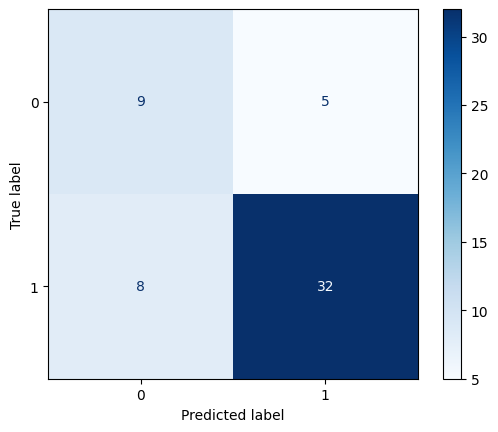

              precision    recall  f1-score   support

           F       0.53      0.64      0.58        14
           P       0.86      0.80      0.83        40

    accuracy                           0.76        54
   macro avg       0.70      0.72      0.71        54
weighted avg       0.78      0.76      0.77        54



In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_display = ConfusionMatrixDisplay(conf_mat)

conf_mat_display.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred))